# **Tarea 1**
## Transformers y Diffusers
### Christian Adrian Sánchez León
#### 10 de septiembre de 2024

# Instrucciones


La tarea de Author Profiling la podemos ver como un problema de clasificación supervisada para identificar rasgos demográficos (e.g., género, edad, nacionalidad, rasgos de personalidad, etc.) de alguna población objetivo. En esta tarea se te proporciona un conjunto de datos de perfiles de usuarios de twitter (solo para español). Cada usuario tiene un conjunto de tweets y en un archivo truth.txt encontrarás las etiquetas objetivo. Para esta tarea solamente las de nacionalidad. Los datos pertenecen a la tarea de aquí: https://pan.webis.de/clef17/pan17-web/author-profiling.html

Con PyTorch haga lo siguiente y ESCRIBA UN BREVE comentario para cada punto. Se debe entregar un notebook/colab que muestre las salidas obtenidas en cada paso.

# 1. **(10pts)** Haga el preprocesamiento que usted considere para limpiar y extraer la información de los documentos. Explique qué hizo y por qué.

## Librerías

In [60]:
import os
import re
import nltk
import torch
import shutil
import random
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET



from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adan-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Distribucion de los datos por etiquetas

In [2]:
import os
import pandas as pd

# ---------------------------------------------------------------
# 1) Ajusta aquí la carpeta raíz si tu dataset no está en el mismo
#    directorio donde corres el notebook.  Si lo está, deja '.'.
# ---------------------------------------------------------------
route = '.'                          # p. ej. '/home/usuario/datasets/PAN23'

# Ruta al truth original de entrenamiento
truth_path = os.path.join(route, 'es_train', 'truth.txt')

# ---------------------------------------------------------------
# 2) Leemos el archivo y construimos el DataFrame
# ---------------------------------------------------------------
rows = []
with open(truth_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Cada línea: file_name:::gender:::country
        file_name, gender, country = line.strip().split(':::')
        rows.append((file_name, gender, country))

df = pd.DataFrame(rows, columns=['file_name', 'gender', 'country'])

# ---------------------------------------------------------------
# 3) Conteos por etiqueta
# ---------------------------------------------------------------
print('――――――――――  Distribución por GÉNERO  ――――――――――')
display(df['gender'].value_counts())       # frecuencia absoluta
print()

print('――――――――――  Distribución por COUNTRY  ―――――――――')
display(df['country'].value_counts())
print()

print('――――――――  Distribución conjunta (gender × country)  ―――――――')
display(df.groupby(['gender', 'country']).size())  # tabla cruzada


――――――――――  Distribución por GÉNERO  ――――――――――


gender
female    2100
male      2100
Name: count, dtype: int64


――――――――――  Distribución por COUNTRY  ―――――――――


country
colombia     600
argentina    600
spain        600
venezuela    600
peru         600
chile        600
mexico       600
Name: count, dtype: int64


――――――――  Distribución conjunta (gender × country)  ―――――――


gender  country  
female  argentina    300
        chile        300
        colombia     300
        mexico       300
        peru         300
        spain        300
        venezuela    300
male    argentina    300
        chile        300
        colombia     300
        mexico       300
        peru         300
        spain        300
        venezuela    300
dtype: int64

## Particion de los datos por etiqueta(ya no correr)

In [3]:
# ---------------------------------------------------------------
# Estratificar al 20 % por GENDER y COUNTRY (copiando los XML)
# ---------------------------------------------------------------
import os
import shutil
import pandas as pd
from pathlib import Path
from datetime import datetime

# ----------------------------------------------------------------
# CONFIGURACIÓN
# ----------------------------------------------------------------
route      = '.'          # ← Pon aquí la carpeta raíz si no es '.'
val_frac   = 0.20         # 20 % para validación
random_seed = 42          # Reproducibilidad

truth_path = os.path.join(route, 'es_train', 'truth.txt')

# ----------------------------------------------------------------
# 1) Cargar truth.txt
# ----------------------------------------------------------------
rows = []
with open(truth_path, 'r', encoding='utf-8') as f:
    for ln in f:
        file_name, gender, country = ln.strip().split(':::')
        rows.append((file_name, gender, country))

df = pd.DataFrame(rows, columns=['file_name', 'gender', 'country'])

# ----------------------------------------------------------------
# 2) Función genérica para estratificar y copiar
# ----------------------------------------------------------------
def make_split(label: str):
    """Crea es_train_<label> y es_val_<label>, estratificados al 20 %."""
    print(f'\n=== Procesando etiqueta: {label.upper()} ===')
    
    train_dir = Path(route) / f'es_train_{label}'
    val_dir   = Path(route) / f'es_val_{label}'
    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    # 2.1  Elegir ejemplos para validación
    def sample_group(g):
        n_val = int(len(g) * val_frac)
        if n_val == 0:
            raise ValueError(f'La clase «{g.name}» de "{label}" tiene < 5 ejemplos; '
                             'reduce val_frac o revisa los datos.')
        return g.sample(n=n_val, random_state=random_seed)
    
    val_df   = df.groupby(label, group_keys=False).apply(sample_group)
    train_df = df[~df.file_name.isin(val_df.file_name)]
    
    print(f'  Train  : {len(train_df)} ejemplos')
    print(f'  Val    : {len(val_df)} ejemplos\n')

    # 2.2  Copiar XMLs
    src_base = Path(route) / 'es_train'
    
    def copy_files(sub_df, dest_dir):
        for fname in sub_df.file_name:
            src  = src_base / f'{fname}.xml'
            dest = dest_dir / f'{fname}.xml'
            if not dest.exists():
                shutil.copy2(src, dest)
    
    copy_files(val_df,   val_dir)
    copy_files(train_df, train_dir)

    # 2.3  Escribir nuevos truth.txt
    def write_truth(sub_df, path):
        with open(path, 'w', encoding='utf-8') as f:
            for _, row in sub_df.iterrows():
                f.write(f"{row.file_name}:::{row.gender}:::{row.country}\n")

    write_truth(train_df, train_dir / 'truth.txt')
    write_truth(val_df,   val_dir   / 'truth.txt')

    # 2.4  Resumen
    by_class = val_df[label].value_counts().sort_index()
    print('  Ejemplos por clase en VAL:')
    print(by_class.to_string(), '\n')

# ----------------------------------------------------------------
# 3) Ejecutar para GENDER y COUNTRY
# ----------------------------------------------------------------
start = datetime.now()
make_split('gender')
make_split('country')
print(f'Hecho. Tiempo total: {datetime.now() - start}')



=== Procesando etiqueta: GENDER ===
  Train  : 3360 ejemplos
  Val    : 840 ejemplos



C:\Users\Adan-\AppData\Local\Temp\ipykernel_25076\3022735337.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df   = df.groupby(label, group_keys=False).apply(sample_group)


  Ejemplos por clase en VAL:
gender
female    420
male      420 


=== Procesando etiqueta: COUNTRY ===
  Train  : 3360 ejemplos
  Val    : 840 ejemplos



C:\Users\Adan-\AppData\Local\Temp\ipykernel_25076\3022735337.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df   = df.groupby(label, group_keys=False).apply(sample_group)


  Ejemplos por clase en VAL:
country
argentina    120
chile        120
colombia     120
mexico       120
peru         120
spain        120
venezuela    120 

Hecho. Tiempo total: 0:00:11.911684


## Funciones

In [61]:
# ================================================================
#  AuthorProfilingDataset – pre-procesamiento sin emojis extra
# ================================================================
import os, re, numpy as np, nltk, xml.etree.ElementTree as ET
import spacy, emoji
from spacy.lang.es.stop_words import STOP_WORDS
from torch.utils.data import Dataset



# ––––– spaCy (tokenizador + tagger, sin parser/ner) –––––
nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])

# --------------- PRE-PROCESADO ---------------
URL_PAT     = re.compile(r'https?://\S+|www\.\S+')
USER_PAT    = re.compile(r'@\w+')
HASH_PAT    = re.compile(r'#(\w+)')
CHAR_FILTER = re.compile(r'[^0-9a-záéíóúñü_ ]+', flags=re.IGNORECASE)  # admite '_'

def preprocess_tweet(text: str) -> str:
    text = text.lower()
    text = URL_PAT.sub("", text)
    text = USER_PAT.sub("", text)
    text = HASH_PAT.sub(lambda m: m.group(1), text)

    # emojis → espacio (se convierten en [UNK] más adelante)
    text = emoji.replace_emoji(text, replace=" ")

    text = CHAR_FILTER.sub(" ", text)

    tokens = [tok.text for tok in nlp(text)
              if tok.text and tok.text not in STOP_WORDS]
    return re.sub(r"\s+", " ", " ".join(tokens)).strip()

# --------------- DATASET ---------------
class AuthorProfilingDataset(Dataset):
    """
    split_dir      : carpeta con truth.txt y XMLs (ej. ./es_train_country)
    label_name     : 'country' o 'gender'
    embedding_path : archivo word2vec (texto) con los embeddings (100-d)
    """

    def __init__(self, split_dir: str, label_name: str = "country",
                 embedding_path: str = "word2vec_col.txt"):
        super().__init__()
        self.split_dir  = split_dir
        self.label_name = label_name.lower()
        if self.label_name not in {"country", "gender"}:
            raise ValueError("label_name debe ser 'country' o 'gender'.")
        self.label_col_ix = 2 if self.label_name == "country" else 1

        self._load_data()                                   # carga textos + etiquetas
        self.vocab, self.emb_mat = self._load_vocab_embeddings(embedding_path)

    # ---------- Dataset API ----------
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentences, label = self.data[idx]
        tokenised = [nltk.word_tokenize(sent) for sent in sentences]
        sent_ids  = [[self.vocab.get(tok, self.vocab["[UNK]"]) for tok in sent]
                     for sent in tokenised]
        return sent_ids, label, sentences

    # ---------- XML + truth.txt ----------
    def _load_data(self):
        truth_path = os.path.join(self.split_dir, "truth.txt")

        with open(truth_path, encoding="utf-8") as f:
            label_vals = sorted({ln.strip().split(":::")[self.label_col_ix] for ln in f})
        self.dict_labels     = {lab: i for i, lab in enumerate(label_vals)}
        self.dict_labels_inv = {i: lab for lab, i in self.dict_labels.items()}

        labels = {}
        with open(truth_path, encoding="utf-8") as f:
            for ln in f:
                parts = ln.strip().split(":::")
                labels[parts[0]] = self.dict_labels[parts[self.label_col_ix]]

        self.data = []
        for fname in os.listdir(self.split_dir):
            if not fname.endswith(".xml"):
                continue
            file_id = fname[:-4]
            label   = labels[file_id]

            tree = ET.parse(os.path.join(self.split_dir, fname))
            root = tree.getroot()

            cleaned_sentences = []
            for doc in root.findall(".//document"):
                raw = doc.text or ""
                proc = preprocess_tweet(raw)
                if proc:
                    cleaned_sentences.append(proc)

            self.data.append((cleaned_sentences, label))

    # ---------- Embeddings ----------
    def _load_vocab_embeddings(self, embedding_path):
        vocab, vocab_inv, emb_list = {}, {}, []

        with open(embedding_path, encoding="utf-8", errors="replace") as f:
            for i, line in enumerate(f):
                # salta cabecera "N dim" si existe
                if i == 0 and re.match(r"^\s*\d+\s+\d+\s*$", line):
                    continue

                vals = line.rstrip().split()
                if not vals:
                    continue
                word, vec_tokens = vals[0], vals[1:]
                try:
                    vec = np.asarray(vec_tokens, dtype="float32")
                except ValueError:
                    print(f"Omitiendo línea {i} – vector corrupto para «{word}»")
                    continue

                new_id = len(vocab) + 2      # +2 por PAD y UNK
                vocab[word]       = new_id
                vocab_inv[new_id] = word
                emb_list.append(vec)

        emb_dim  = emb_list[0].shape[0] if emb_list else 100  # 100-d por defecto
        mean_vec = np.mean(np.vstack(emb_list), axis=0) if emb_list else np.zeros(emb_dim)

        emb_list.insert(0, mean_vec)           # idx 1 → UNK
        emb_list.insert(0, np.zeros(emb_dim))  # idx 0 → PAD
        vocab["[PAD]"]  = 0
        vocab["[UNK]"]  = 1
        vocab_inv[0]    = "[PAD]"
        vocab_inv[1]    = "[UNK]"

        self.vocab_dict = vocab_inv
        return vocab, np.vstack(emb_list)


In [62]:
import random, torch

# ------------------------------------------------------------
#  collate_fn – agrupa documentos en un batch fijo
# ------------------------------------------------------------
def collate_fn(batch):
    """
    batch: lista de tuplas (sent_ids, label, sent_texts)
    Devuelve:
        sentence_ids      – tensor  (B, max_num_sents, fixed_num_words)
        labels            – tensor  (B,)
        processed_sentences – lista  (B) con las frases en texto
    """
    zipped_batch = list(zip(*batch))

    fixed_num_words = 16    # tokens por oración
    max_num_sents   = 100   # oraciones por documento

    padded_batch_sentences = []
    processed_sentences    = []

    # --- procesar cada documento ---
    for sent_ids, sent_words in zip(zipped_batch[0], zipped_batch[2]):
        padded_sentences = []
        proc_sentences   = []

        # emparejar ids ↔ texto y recortar a max_num_sents
        sent_pairs = list(zip(sent_ids, sent_words))
        if len(sent_pairs) > max_num_sents:
            # si deseas reproducibilidad, fija random.seed(seed)
            sent_pairs = random.sample(sent_pairs, max_num_sents)

        for ids, words in sent_pairs:
            # truncar o padear cada oración
            if len(ids) > fixed_num_words:
                proc_sentences.append(words[:fixed_num_words])
                padded = torch.tensor(ids[:fixed_num_words], dtype=torch.long)
            else:
                proc_sentences.append(words)
                pad_len = fixed_num_words - len(ids)
                padded  = torch.cat([torch.tensor(ids, dtype=torch.long),
                                     torch.zeros(pad_len, dtype=torch.long)])
            padded_sentences.append(padded)

        # pad de oraciones vacías si el doc tiene < max_num_sents
        while len(padded_sentences) < max_num_sents:
            padded_sentences.append(torch.zeros(fixed_num_words, dtype=torch.long))

        padded_batch_sentences.append(torch.stack(padded_sentences))
        processed_sentences.append(proc_sentences)

    # stack final
    sentence_ids = torch.stack(padded_batch_sentences, dim=0)  # (B, S, W)
    labels       = torch.tensor(zipped_batch[1], dtype=torch.long)

    return sentence_ids, labels, processed_sentences


In [63]:
# ------------------------------------------------------------
#  util_embeddings.py  – carga sencillísima de Word2Vec 100-d
# ------------------------------------------------------------
import numpy as np

def load_word2vec_txt(path):
    """
    Lee un archivo .txt en formato Word2Vec/GloVe y devuelve:
        vocab  : dict  token → fila
        emb_mat: ndarray shape (vocab_size, dim)
    Descarta la cabecera "N dim" si existe.
    """
    vocab, vectors = {}, []

    with open(path, encoding="utf-8") as f:
        for i, line in enumerate(f, 1):
            if i == 1 and len(line.split()) == 2 and line.split()[0].isdigit():
                # línea-cabecera; la ignoramos
                continue
            parts = line.rstrip().split()
            if len(parts) <= 2:          # línea vacía o corrupta
                continue
            token, vec = parts[0], parts[1:]
            vectors.append(np.asarray(vec, dtype="float32"))
            vocab[token] = len(vectors) - 1

    emb_mat = np.vstack(vectors)
    return vocab, emb_mat            # (vocab_size, dim)


## Solución

In [69]:
# Remove the drive.mount line since it's only for Google Colab
# drive.mount('/content/gdrive')

# Set the route to the local working directory
route = "./"


In [48]:
# NO CORRER ESTE BLOQUE DE CÓDIGO
# Creamos un conjunto de validación con el 20% de los datos de entrenamiento
# create_val_dataset(route)

In [64]:
# ------------------------------------------------------------
# 1. Imports y parámetros generales
# ------------------------------------------------------------
from torch.utils.data import DataLoader, random_split
import os, torch

batch_size = 16
label      = 'gender'   # usa 'country' si es la otra tarea
route      = "./"       # ajusta la ruta base a tu entorno

# ------------------------------------------------------------
# 2. Rutas de los splits
# ------------------------------------------------------------
train_path = os.path.join(route, f'es_train_{label}')
val_path   = os.path.join(route, f'es_val_{label}')
test_path  = os.path.join(route, 'es_test')

# ------------------------------------------------------------
# 3. Dataset de entrenamiento
# ------------------------------------------------------------
train_dataset = AuthorProfilingDataset(train_path, label_name=label)
# (El propio AuthorProfilingDataset carga el Word2Vec y crea
#  vocab/emb_mat; no necesitamos sobreescribir nada.)

# ------------------------------------------------------------
# 4. Dataset de validación
# ------------------------------------------------------------
if os.path.exists(val_path):
    val_dataset = AuthorProfilingDataset(val_path, label_name=label)
else:
    # Si no hay carpeta de validación, dividimos el train
    val_ratio   = 0.20
    val_size    = int(len(train_dataset) * val_ratio)
    train_size  = len(train_dataset) - val_size

    train_dataset, val_dataset = random_split(
        train_dataset, [train_size, val_size]
    )

# ------------------------------------------------------------
# 5. Dataset de test
# ------------------------------------------------------------
test_dataset = AuthorProfilingDataset(test_path, label_name=label)

# ------------------------------------------------------------
# 6. DataLoaders finales
# ------------------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, shuffle=True)

val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                          collate_fn=collate_fn, shuffle=False)

test_loader  = DataLoader(test_dataset,  batch_size=batch_size,
                          collate_fn=collate_fn, shuffle=False)


## Discusión

El preprocesamiento que realicé de los documentos incluyó varias acciones. Primero, creé un conjunto de validación balanceado utilizando el 20% de los documentos de entrenamiento. Luego, eliminé URLs presentes en las oraciones para evitar información irrelevante, y posteriormente, convertí todas las oraciones a minúsculas.

Además, definí un vocabulario basado únicamente en las palabras con embeddings pre-entrenados, lo que permitió aprovechar toda la información del archivo word2vec_col.txt. Para procesar los documentos en batches, agregué palabras de padding a cada oración para que todos los documentos de un mismo batch tuvieran el mismo tamaño.

# 2. (**40pts**) Diseñe un clasificador con alguna RNN con atención en jerarquía (como en el paper adjunto) que codifique cada perfil de usuario con todos sus tweets y clasifique. El primer nivel intuitivamente recibe embeddings de palabras, el segundo de tweets. Discuta brevemente el rendimiento del modelo.

## Librerías

In [22]:
import copy
import torch.nn.functional as F

from tqdm.auto import tqdm
from torch import nn, optim
from sklearn.metrics import f1_score

## Funciones

In [65]:
class AttnModule(nn.Module):
    def __init__(self, hidden_dim, attention_dim, use_attention=True):
        super(AttnModule, self).__init__()
        self.use_attention = use_attention
        if use_attention:
            self.attention_layer = nn.Linear(hidden_dim, attention_dim)
            self.context_vector = nn.Linear(attention_dim, 1, bias=False)

    def forward(self, hidden_outputs):
        if self.use_attention:
            u = torch.tanh(self.attention_layer(hidden_outputs))
            alpha = F.softmax(self.context_vector(u), dim=1)
            v = torch.sum(alpha * hidden_outputs, dim=1)
            return v, alpha.squeeze(-1)
        else:
            v = torch.mean(hidden_outputs, dim=1)
            return v, None

In [66]:
class HAN(nn.Module):
    def __init__(self, emb_mat, word_gru_hidden_dim=50, word_attention_dim=50,
                 sent_gru_hidden_dim=50, sent_attention_dim=50, num_classes=7,
                 attention=True):
        super(HAN, self).__init__()
        self.attention = attention
        # Embeddings
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(emb_mat, dtype=torch.float32), freeze=False
        )
        # GRU word-level
        self.word_gru = nn.GRU(
            emb_mat.shape[1], word_gru_hidden_dim,
            bidirectional=True, batch_first=True
        )
        self.word_attention = AttnModule(
            word_gru_hidden_dim * 2, word_attention_dim,
            use_attention=self.attention
        )
        # GRU sentence-level
        self.sent_gru = nn.GRU(
            word_gru_hidden_dim * 2, sent_gru_hidden_dim,
            bidirectional=True, batch_first=True
        )
        self.sent_attention = AttnModule(
            sent_gru_hidden_dim * 2, sent_attention_dim,
            use_attention=self.attention
        )
        # Classifier
        self.classifier = nn.Linear(sent_gru_hidden_dim * 2, num_classes)

    def forward(self, input_docs, return_hidden: bool = False):
        batch_size, num_sents, num_words = input_docs.size()
        docs_flat = input_docs.view(-1, num_words)
        word_embeds = self.embedding(docs_flat)
        word_gru_out, _ = self.word_gru(word_embeds)
        sent_vectors, word_attention_scores = self.word_attention(word_gru_out)
        sent_vectors = sent_vectors.view(batch_size, num_sents, -1)
        sent_gru_out, _ = self.sent_gru(sent_vectors)
        doc_vectors, sent_attention_scores = self.sent_attention(sent_gru_out)
        output = self.classifier(doc_vectors)
        if word_attention_scores is not None:
            word_attention_scores = word_attention_scores.view(batch_size, num_sents, -1)
        # Devuelve hidden rectificado solo cuando se solicite para Cockatiel
        if return_hidden:
            hidden_nonneg = F.relu(doc_vectors)
            return output, hidden_nonneg, word_attention_scores, sent_attention_scores
        return output, word_attention_scores, sent_attention_scores

    def encode_doc(self, input_docs):
        batch, sents, words = input_docs.size()
        word_embeds = self.embedding(input_docs.view(-1, words))
        word_gru_out, _ = self.word_gru(word_embeds)
        sent_vecs, _ = self.word_attention(word_gru_out)
        sent_vecs = sent_vecs.view(batch, sents, -1)
        sent_gru_out, _ = self.sent_gru(sent_vecs)
        doc_vec, _ = self.sent_attention(sent_gru_out)
        return doc_vec

In [67]:
# Función para evaluar el modelo
def eval_model(model, dataloader, criterion, device):
    model.eval()

    with torch.no_grad():
        losses = []
        preds = torch.empty(0).long()
        targets = torch.empty(0).long()
        word_attention_scores_list = []
        sent_attention_scores_list = []
        sent_list = []
        pred_list = []
        labels_list = []

        for data in tqdm(dataloader):
            torch.cuda.empty_cache()

            input_docs, labels, sentences = data
            input_docs, labels = input_docs.to(device), labels.to(device)

            output, word_attention_scores, sent_attention_scores = model(input_docs)

            loss = criterion(output, labels)
            losses.append(loss.item())

            predictions = F.softmax(output, dim = 1).argmax(1)
            preds = torch.cat([preds, predictions.cpu()], dim = 0)
            targets = torch.cat([targets, labels.cpu()], dim = 0)

            if word_attention_scores is not None:
                labels_list += labels.tolist()
                pred_list += predictions.tolist()
                word_attention_scores = word_attention_scores.cpu().detach().tolist()
                sent_attention_scores = sent_attention_scores.cpu().detach().tolist()
                word_attention_scores_list += word_attention_scores
                sent_attention_scores_list += sent_attention_scores
                sent_list += sentences

        preds = preds.numpy()
        targets = targets.numpy()

        # Calculamos la exactitud (en este caso, como las clases son balanceadas, la exactitud es una métrica adecuada)
        acc = (preds == targets).mean()

        return np.mean(losses), acc, word_attention_scores_list, sent_attention_scores_list, sent_list, pred_list, labels_list

## Solución Country

In [68]:
# Definimos el número de épocas y el dispositivo en que se entrenará la red, cuda o cpu
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
num_classes

2

In [71]:
import torch, torch.nn as nn, torch.optim as optim

#1) Accedemos al dataset "base" (por si train_dataset es un Subset)
base_ds = train_dataset.dataset if isinstance(train_dataset, torch.utils.data.Subset) else train_dataset

# 2) Matriz de embeddings y nº de clases
emb_mat      = base_ds.emb_mat
num_classes  = len(base_ds.dict_labels)

# 3) Modelo HAN
model = HAN(emb_mat=emb_mat, num_classes=num_classes).to(device)

#4) Optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [27]:
import copy
from tqdm.auto import tqdm

best_val_acc   = 0.0
best_state_dict = None
epochs         = 10               # número de épocas
clip_grad_norm = 5.0              # opcional, para estabilidad

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for input_docs, labels, _ in pbar:
        input_docs, labels = input_docs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits, _, _ = model(input_docs)
        loss = criterion(logits, labels)
        loss.backward()

        # opcional: recorte de gradiente
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

        optimizer.step()
        pbar.set_postfix(loss=loss.item())

    # -------- evaluación en train y val ----------
    train_loss, train_acc, *_ = eval_model(model, train_loader, criterion, device)
    val_loss,   val_acc,   *_ = eval_model(model, val_loader,   criterion, device)

    print(f"epoch {epoch+1:02d}: "
          f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"train_acc={train_acc:.4f}   val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_state_dict = copy.deepcopy(model.state_dict())
        print("» Nuevo mejor modelo (val_acc)")


Epoch 1/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 01: train_loss=0.5378  val_loss=0.5701  train_acc=0.7220   val_acc=0.7083
» Nuevo mejor modelo (val_acc)


Epoch 2/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 02: train_loss=0.4178  val_loss=0.5331  train_acc=0.8336   val_acc=0.7464
» Nuevo mejor modelo (val_acc)


Epoch 3/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 03: train_loss=0.2123  val_loss=0.4984  train_acc=0.9381   val_acc=0.7762
» Nuevo mejor modelo (val_acc)


Epoch 4/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 04: train_loss=0.1803  val_loss=0.7422  train_acc=0.9226   val_acc=0.7202


Epoch 5/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 05: train_loss=0.0183  val_loss=0.7294  train_acc=0.9976   val_acc=0.7619


Epoch 6/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 06: train_loss=0.0076  val_loss=0.8504  train_acc=0.9982   val_acc=0.7488


Epoch 7/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 07: train_loss=0.0030  val_loss=0.9746  train_acc=0.9985   val_acc=0.7560


Epoch 8/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 08: train_loss=0.0026  val_loss=1.1094  train_acc=0.9994   val_acc=0.7536


Epoch 9/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 09: train_loss=0.0015  val_loss=1.1500  train_acc=0.9994   val_acc=0.7714


Epoch 10/10:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch 10: train_loss=0.0264  val_loss=1.4788  train_acc=0.9929   val_acc=0.7286


## Guardamos modelo Gender

In [33]:
import json, pickle, torch, os

save_dir = "runs"
os.makedirs(save_dir, exist_ok=True)

# 1) pesos del modelo
torch.save(best_state_dict, f"{save_dir}/han_state_gender.pt")

# 2) vocabulario
with open(f"{save_dir}/vocab_gender.pkl", "wb") as f:
    pickle.dump(base_ds.vocab, f)              # token → id

# 3) etiquetas
with open(f"{save_dir}/label_map_gender.json", "w", encoding="utf8") as f:
    json.dump(base_ds.dict_labels_inv, f, ensure_ascii=False, indent=2)


## Guardamos modelo country

In [166]:
import json, pickle, torch, os

save_dir = "runs"
os.makedirs(save_dir, exist_ok=True)

# 1) pesos del modelo
torch.save(best_state_dict, f"{save_dir}/han_state_country.pt")

# 2) vocabulario
with open(f"{save_dir}/vocab_country.pkl", "wb") as f:
    pickle.dump(base_ds.vocab, f)              # token → id

# 3) etiquetas
with open(f"{save_dir}/label_map_country.json", "w", encoding="utf8") as f:
    json.dump(base_ds.dict_labels_inv, f, ensure_ascii=False, indent=2)


### Funciones para guardar y cargar dataloaders

In [14]:
import torch, os, pickle
from pathlib import Path
from tqdm.auto import tqdm

def dump_loader(loader, path):
    """
    Serializa todos los batches de un DataLoader a un único archivo .pt.
    Guarda:
        ids       – LongTensor (N, S, W)
        labels    – LongTensor (N,)
        sentences – lista(len=N) de listas de strings (opcional, para atención)
    """
    path = Path(path); path.parent.mkdir(parents=True, exist_ok=True)

    ids_all, labels_all, sents_all = [], [], []
    for ids, labels, sents in tqdm(loader, desc=f"dump → {path.name}"):
        ids_all.append(ids)
        labels_all.append(labels)
        sents_all.extend(sents)          # lista pura de python

    ids_all    = torch.cat(ids_all)      # (N,S,W)
    labels_all = torch.cat(labels_all)   # (N,)

    torch.save({"ids": ids_all,
                "labels": labels_all,
                "sentences": sents_all}, path)


from torch.utils.data import DataLoader, Dataset
import torch

def load_loader(path, batch_size=16, shuffle=False):
    blob = torch.load(path, map_location="cpu")
    ids, labels, sents = blob["ids"], blob["labels"], blob["sentences"]

    class DumpedDataset(Dataset):
        def __len__(self): return labels.size(0)
        def __getitem__(self, idx):
            # devolvemos EXACTAMENTE lo que espera eval_model
            return ids[idx], labels[idx], sents[idx]

    def collate(batch):
        # ids y labels a tensores; sentences queda como lista de listas
        ids_b     = torch.stack([x[0] for x in batch])      # (B,S,W)
        labels_b  = torch.stack([x[1] for x in batch])      # (B,)
        sents_b   = [x[2] for x in batch]                   # len B
        return ids_b, labels_b, sents_b

    ds = DumpedDataset()
    return DataLoader(ds, batch_size=batch_size,
                      shuffle=shuffle, collate_fn=collate)



## Guardamos data loader gender

In [188]:
dump_loader(train_loader, "runs/train_dl_gender.pt")
dump_loader(val_loader,   "runs/val_dl_gender.pt")
dump_loader(test_loader,  "runs/test_dl_gender.pt")


dump → train_dl_gender.pt:   0%|          | 0/210 [00:00<?, ?it/s]

dump → val_dl_gender.pt:   0%|          | 0/53 [00:00<?, ?it/s]

dump → test_dl_gender.pt:   0%|          | 0/175 [00:00<?, ?it/s]

## Guardamos data loaders country

In [169]:
dump_loader(train_loader, "runs/train_dl_country.pt")
dump_loader(val_loader,   "runs/val_dl_country.pt")
dump_loader(test_loader,  "runs/test_dl_country.pt")


dump → train_dl_country.pt:   0%|          | 0/210 [00:00<?, ?it/s]

dump → val_dl_country.pt:   0%|          | 0/53 [00:00<?, ?it/s]

dump → test_dl_country.pt:   0%|          | 0/175 [00:00<?, ?it/s]

## Cargar modelo country

In [75]:
import json, pickle, torch, numpy as np
from pathlib import Path

load_dir = Path("runs")
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 1) vocabulario y etiquetas ────────────────────────────
with open(load_dir / "vocab_country.pkl", "rb") as f:
    vocab_country = pickle.load(f)                       # token → id
with open(load_dir / "label_map_country.json") as f:
    idx2label_country = json.load(f)                     # id → etiqueta

num_classes_country = len(idx2label_country)

# ── 2) reconstruir el modelo (dummy emb_mat del tamaño correcto) ──
state_country = torch.load(load_dir / "han_state_country.pt", map_location="cpu")
vocab_size_country, emb_dim_country = state_country["embedding.weight"].shape
dummy_emb_mat_country = np.zeros((vocab_size_country, emb_dim_country), dtype=np.float32)

model_country = HAN(dummy_emb_mat_country, num_classes=num_classes_country).to(device)
model_country.load_state_dict(state_country)
model_country.eval()


C:\Users\Adan-\AppData\Local\Temp\ipykernel_35688\3499347609.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_country = torch.load(load_dir / "han_state_country.pt

HAN(
  (embedding): Embedding(973267, 100)
  (word_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (word_attention): AttnModule(
    (attention_layer): Linear(in_features=100, out_features=50, bias=True)
    (context_vector): Linear(in_features=50, out_features=1, bias=False)
  )
  (sent_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (sent_attention): AttnModule(
    (attention_layer): Linear(in_features=100, out_features=50, bias=True)
    (context_vector): Linear(in_features=50, out_features=1, bias=False)
  )
  (classifier): Linear(in_features=100, out_features=7, bias=True)
)

## Cargamos modelo gender

In [74]:
import json, pickle, torch, numpy as np
from pathlib import Path

load_dir = Path("runs")
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 1) vocabulario y etiquetas ────────────────────────────
with open(load_dir / "vocab_gender.pkl", "rb") as f:
    vocab_gender= pickle.load(f)                       # token → id
with open(load_dir / "label_map_gender.json") as f:
    idx2label_gender = json.load(f)                     # id → etiqueta

num_classes_gender = len(idx2label_gender)

# ── 2) reconstruir el modelo (dummy emb_mat del tamaño correcto) ──
state_gender = torch.load(load_dir / "han_state_gender.pt", map_location="cpu")
vocab_size_gender, emb_dim_gender = state_gender["embedding.weight"].shape
dummy_emb_mat_gender = np.zeros((vocab_size_gender, emb_dim_gender), dtype=np.float32)

model_gender = HAN(dummy_emb_mat_gender, num_classes=num_classes_gender).to(device)
model_gender.load_state_dict(state_gender)
model_gender.eval()


C:\Users\Adan-\AppData\Local\Temp\ipykernel_35688\2304590973.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_gender = torch.load(load_dir / "han_state_gender.pt",

RuntimeError: Error(s) in loading state_dict for HAN:
	size mismatch for classifier.weight: copying a param with shape torch.Size([7, 100]) from checkpoint, the shape in current model is torch.Size([2, 100]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([2]).

## Cargar dataloader gender

In [73]:
train_loader = load_loader("runs/train_dl_gender.pt", batch_size=16)
val_loader = load_loader("runs/val_dl_gender.pt",   batch_size=16)
test_loader = load_loader("runs/test_dl_gender.pt",  batch_size=16)

model = model_gender
optimizer = optim.Adam(model_gender.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

C:\Users\Adan-\AppData\Local\Temp\ipykernel_35688\395710321.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blob = torch.load(path, map_location="cpu")


## Cargar dataloaders country

In [76]:
train_loader = load_loader("runs/train_dl_country.pt", batch_size=16)
val_loader = load_loader("runs/val_dl_country.pt",   batch_size=16)
test_loader = load_loader("runs/test_dl_country.pt",  batch_size=16)

model = model_country
optimizer = optim.Adam(model_country.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

C:\Users\Adan-\AppData\Local\Temp\ipykernel_35688\395710321.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blob = torch.load(path, map_location="cpu")


## Evaluar modelo

### Gender

In [34]:
# Cargamos el mejor modelo y lo evaluamos en los tres conjuntos


train_loss, train_acc, train_w_scores, train_s_scores, train_sents, train_pred, train_labels = eval_model(model, train_loader, criterion, device)
val_loss, val_acc, val_w_scores, val_s_scores, val_sents, val_pred, val_labels = eval_model(model, val_loader, criterion, device)
test_loss, test_acc, test_w_scores, test_s_scores, test_sents, test_pred, test_labels = eval_model(model, test_loader, criterion, device)

print('train_loss: %5f | train_acc: %5f'%(train_loss, train_acc))
print('val_loss: %5f | val_acc: %5f'%(val_loss, val_acc))
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_acc))

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

train_loss: 0.692142 | train_acc: 0.506548
val_loss: 0.692597 | val_acc: 0.504762
test_loss: 0.692496 | test_acc: 0.504643


### Country

In [77]:
# Cargamos el mejor modelo y lo evaluamos en los tres conjuntos


train_loss, train_acc, train_w_scores, train_s_scores, train_sents, train_pred, train_labels = eval_model(model_country, train_loader, criterion, device)
val_loss, val_acc, val_w_scores, val_s_scores, val_sents, val_pred, val_labels = eval_model(model_country, val_loader, criterion, device)
test_loss, test_acc, test_w_scores, test_s_scores, test_sents, test_pred, test_labels = eval_model(model_country, test_loader, criterion, device)

print('train_loss: %5f | train_acc: %5f'%(train_loss, train_acc))
print('val_loss: %5f | val_acc: %5f'%(val_loss, val_acc))
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_acc))

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

train_loss: 0.007005 | train_acc: 0.998512
val_loss: 0.488541 | val_acc: 0.875000
test_loss: 0.414885 | test_acc: 0.899643


In [29]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Empaqueta tus splits y sus datos
splits = {
    "train": (train_pred, train_labels),
    "val":   (val_pred,   val_labels),
    "test":  (test_pred,  test_labels)
}

for name, (preds, labels) in splits.items():
    print(f"\n=== Métricas en {name} ===")
    print("Accuracy       :", accuracy_score(labels, preds))
    print("Precision macro:", precision_score(labels, preds, average="macro"))
    print("Precision micro:", precision_score(labels, preds, average="micro"))
    print("Recall macro   :", recall_score(labels, preds, average="macro"))
    print("Recall micro   :", recall_score(labels, preds, average="micro"))
    print("F1 macro       :", f1_score(labels, preds, average="macro"))
    print("F1 micro       :", f1_score(labels, preds, average="micro"))
    
    # Reporte detallado por clase
    print("\nReporte por clase:")
    print(classification_report(labels, preds, digits=4))
    
    # (Opcional) matriz de confusión
    cm = confusion_matrix(labels, preds)
    print("Matriz de confusión:")
    print(cm)



=== Métricas en train ===
Accuracy       : 0.9928571428571429
Precision macro: 0.9929416750888403
Precision micro: 0.9928571428571429
Recall macro   : 0.9928571428571429
Recall micro   : 0.9928571428571429
F1 macro       : 0.9928568366203341
F1 micro       : 0.9928571428571429

Reporte por clase:
              precision    recall  f1-score   support

           0     0.9865    0.9994    0.9929      1680
           1     0.9994    0.9863    0.9928      1680

    accuracy                         0.9929      3360
   macro avg     0.9929    0.9929    0.9929      3360
weighted avg     0.9929    0.9929    0.9929      3360

Matriz de confusión:
[[1679    1]
 [  23 1657]]

=== Métricas en val ===
Accuracy       : 0.7285714285714285
Precision macro: 0.7640748211993398
Precision micro: 0.7285714285714285
Recall macro   : 0.7285714285714285
Recall micro   : 0.7285714285714285
F1 macro       : 0.7191311132098714
F1 micro       : 0.7285714285714285

Reporte por clase:
              precision    re

C:\Users\Adan-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adan-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adan-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [30]:
import sys
import torch
import sklearn
import nltk
import wordcloud
import matplotlib
import pandas as pd
import numpy as np

def print_env_info():
    print("=== Entorno de Python ===")
    print("Python       :", sys.version.replace('\n', ' '))
    print()
    print("=== Librerías ===")
    print("PyTorch      :", torch.__version__)
    print("  CUDA        :", torch.version.cuda, "| Available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("  GPU         :", torch.cuda.get_device_name(0))
    print("scikit-learn :", sklearn.__version__)
    print("NLTK         :", nltk.__version__)
    print("WordCloud    :", wordcloud.__version__)
    print("matplotlib   :", matplotlib.__version__)
    print("pandas       :", pd.__version__)
    print("NumPy        :", np.__version__)
    print()
    print("=== Entrenamiento HAN ===")
    print("Optimizer    : Adam(lr=1e-3)")
    print("Criterion    : CrossEntropyLoss")
    print("Batch size   : 16")

if __name__ == "__main__":
    print_env_info()


=== Entorno de Python ===
Python       : 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]

=== Librerías ===
PyTorch      : 2.5.1+cpu
  CUDA        : None | Available: False
scikit-learn : 1.5.2
NLTK         : 3.9.1
WordCloud    : 1.9.4
matplotlib   : 3.9.2
pandas       : 2.2.3
NumPy        : 1.26.4

=== Entrenamiento HAN ===
Optimizer    : Adam(lr=1e-3)
Criterion    : CrossEntropyLoss
Batch size   : 16


# Wrapper

### Funciones

In [78]:
from typing import Any, List


def load_list_pickle(file_path: str | Path) -> List[Any]:

    file_path = Path(file_path)
    with file_path.open("rb") as f:
        data = pickle.load(f)                              # deserializa de vuelta :contentReference[oaicite:1]{index=1}
    if not isinstance(data, list):
        raise TypeError(f"El objeto en {file_path} no es una lista.")
    return data

### Clase Wrapper

In [80]:
import torch
import numpy as np
import nltk
from typing import List, Optional

class BatchTweetListWrapper:
    """
    Wrapper que recibe una lista de listas de tweets (crudos o ya preprocesados),
    y devuelve una matriz de probabilidades (o logits) por clase para cada autor.
    """
    def __init__(self,
                 model: torch.nn.Module,
                 vocab: dict,
                 preprocess_fn: Optional[callable] = None,
                 device: str = "cpu",
                 fixed_num_words: int = 16,
                 max_num_sents: int = 100):
        self.model = model.eval().to(device)
        self.vocab = vocab
        self.pre   = preprocess_fn
        self.device = torch.device(device)
        self.W = fixed_num_words
        self.S = max_num_sents
        self.pad = vocab["[PAD]"]
        self.unk = vocab["[UNK]"]

    def __call__(self,
                 batch_tweets: List[List[str]],
                 return_probs: bool = True) -> np.ndarray:
        """
        batch_tweets: lista de listas de strings; 
                      cada sublista son los tweets de un autor/documento.
        return_probs: si True retorna probabilidades, si False logits.
        ---
        Devuelve un array shape (B, n_classes).
        """
        batch_ids = []
        for tweets in batch_tweets:
            # 1) Preprocesar cada tweet si procede
            proc_sents = [self.pre(t) if self.pre is not None else t for t in tweets]
            proc_sents = [s for s in proc_sents if s]

            # 2) Limitar a S oraciones (tweets)
            proc_sents = proc_sents[:self.S]

            # 3) Tokenizar + ids + trunc/pad a W tokens
            ids_list = []
            for sent in proc_sents:
                toks = nltk.word_tokenize(sent)
                ids = [self.vocab.get(w, self.unk) for w in toks][:self.W]
                ids += [self.pad] * (self.W - len(ids))
                ids_list.append(ids)

            # 4) Pad de oraciones vacías hasta S
            while len(ids_list) < self.S:
                ids_list.append([self.pad] * self.W)

            batch_ids.append(torch.tensor(ids_list, dtype=torch.long))

        # 5) Crear tensor (B, S, W)
        x = torch.stack(batch_ids, dim=0).to(self.device)

        # 6) Inferencia
        with torch.no_grad():
            logits, *_ = self.model(x)
            if return_probs:
                return torch.softmax(logits, dim=-1).cpu().numpy()
            else:
                return logits.cpu().numpy()




### Uso del Wrapper

#### Country

In [202]:

# id a clase
# [argentina, chile, colombia, mexico, peru, spain, venezuela]


In [89]:
tweet_data_preprocessed_2[1500]['country']

'spain'

In [90]:

wrapper = BatchTweetListWrapper(model_country, vocab_country, preprocess_fn=None, device=device)
batch = [tweet_data_preprocessed_2[1500]['tweets'], tweet_data_preprocessed_2[1]['tweets']]


probs_matrix = wrapper(batch)        # shape (len(batch), num_classes)
preds = probs_matrix.argmax(axis=1)
print(probs_matrix)

[[5.4960e-06 1.0949e-05 9.3777e-06 2.0753e-06 9.5648e-06 9.9994e-01
  2.2796e-05]
 [1.5368e-04 5.2267e-05 9.9725e-01 1.8297e-03 1.4938e-05 2.8619e-04
  4.1236e-04]]


#### Gender

In [79]:
tweet_data_preprocessed_2 = load_list_pickle("Tweet_data_preprocessed_2.pkl")

In [45]:
wrapper_gender = BatchTweetListWrapper(model_gender, vocab_gender, preprocess_fn=None, device=device)
batch = [tweet_data_preprocessed_2[0]['tweets'], tweet_data_preprocessed_2[1]['tweets']]

# ---- Modo A: texto crudo ----
probs_matrix = wrapper_gender(batch)        # shape (len(batch), num_classes)
preds = probs_matrix.argmax(axis=1)
print(probs_matrix)

NameError: name 'model_gender' is not defined

# Lime

### Funciones

In [91]:
from EvoMSA import BoW, DenseBoW, StackGeneralization
from EvoMSA.tests.test_base import TWEETS
from microtc.utils import tweet_iterator
from IngeoML import SelectFromModelCV
from CompStats import CI, StatisticSamples
from CompStats import performance, difference, plot_difference
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from typing import Any
from pathlib import Path
from typing import List
import re
import spacy
import unicodedata
from functools import lru_cache
import pickle
np.set_printoptions(precision=4)
sns.set_style('whitegrid')
import random
from typing import Union, List, Tuple




def split_tweet_data(
    tweet_data: List[dict],
    label_key: str,
    *,
    train_size: Union[int, float, None] = None,
    test_size: Union[int, float, None] = None,
    seed: int = 42
):
    """
    Divide tweet_data en conjuntos train/test sin reemplazo, permitiendo indicar
    explícitamente train_size o test_size (o ambos) como número de autores o fracción.

    Parámetros:
    - tweet_data: lista de dicts con keys 'tweets' (list[str]) y label_key:str
    - label_key: 'gender' o 'country'
    - train_size: si es int, número de autores en train; si es float en (0,1), fracción de autores; None para derivar.
    - test_size:  si es int, número de autores en test;  si es float en (0,1), fracción de autores; None para derivar.
    - seed: semilla aleatoria para reproducibilidad

    Retorna:
    - X_train: list[str]        todos los tweets del conjunto de train (aplanados)
    - y_train: np.ndarray       etiquetas correspondientes por tweet
    - X_test:  list[list[str]]  cada sublista = tweets de un autor en test
    - y_test:  np.ndarray       etiqueta por autor en test
    - X_train_grouped: list[list[str]]  cada sublista = tweets de un autor en train
    - y_train_grouped: np.ndarray       etiqueta por autor en train
    """
    N = len(tweet_data)
    if N == 0:
        return [], np.array([]), [], np.array([]), [], np.array([])

    # Helper para convertir tamaño
    def to_count(x, total):
        if x is None:
            return None
        if isinstance(x, float):
            return int(total * x)
        return int(x)

    train_cnt = to_count(train_size, N)
    test_cnt  = to_count(test_size,  N)

    # Derivar si hace falta
    if train_cnt is None and test_cnt is None:
        test_cnt  = int(0.2 * N)
        train_cnt = N - test_cnt
    elif train_cnt is None:
        train_cnt = N - test_cnt
    elif test_cnt is None:
        test_cnt = N - train_cnt

    # Ajustar rangos
    train_cnt = max(0, min(train_cnt, N))
    test_cnt  = max(0, min(test_cnt,  N - train_cnt))

    # Barajar índices
    indices = list(range(N))
    random.seed(seed)
    random.shuffle(indices)

    train_idx = indices[:train_cnt]
    test_idx  = indices[train_cnt:train_cnt + test_cnt]

    # Construir X_train plano y y_train plano
    X_train, y_train = [], []
    for i in train_idx:
        label = tweet_data[i][label_key]
        for tw in tweet_data[i]['tweets']:
            X_train.append(tw)
            y_train.append(label)

    # Construir X_test agrupado y y_test
    X_test, y_test = [], []
    for i in test_idx:
        X_test.append(list(tweet_data[i]['tweets']))
        y_test.append(tweet_data[i][label_key])

    # Construir X_train agrupado y y_train agrupado
    X_train_grouped, y_train_grouped = [], []
    for i in train_idx:
        X_train_grouped.append(list(tweet_data[i]['tweets']))
        y_train_grouped.append(tweet_data[i][label_key])

    return (
        X_train,
        np.array(y_train),
        X_test,
        np.array(y_test),
        X_train_grouped,
        np.array(y_train_grouped),
    )





def load_object_pickle(file_path: str | Path) -> Any:

    file_path = Path(file_path)
    with file_path.open("rb") as f:
        obj = pickle.load(f)
    return obj




import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def evaluate_binary_classification(y_true, y_pred, class_names=None, figsize=(8, 6)):
    """
    Calcula métricas de clasificación binaria y muestra una matriz de confusión.

    Parámetros:
    - y_true: array-like de etiquetas reales (tienen dos clases).
    - y_pred: array-like de etiquetas predichas.
    - class_names: lista de etiquetas en el orden [negativo, positivo].
                   Si es None, se inferirá de y_true ∪ y_pred.
    - figsize: tupla con el tamaño de la figura (ancho, alto) en pulgadas.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Determinar etiquetas
    if class_names is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
        class_names = [str(l) for l in labels]
    else:
        labels = class_names

    # Métricas
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=labels[1])
    recall = recall_score(y_true, y_pred, pos_label=labels[1])
    f1 = f1_score(y_true, y_pred, pos_label=labels[1])

    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-score       : {f1:.4f}\n")

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.set_title('Matriz de Confusión')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.colorbar(im, ax=ax)

    # Poner ticks y anotaciones
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')

    plt.tight_layout()
    plt.show()





import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

def evaluate_multiclass_classification(
    y_true,
    y_pred,
    labels=None,
    class_names=None,
    figsize=(8, 6),
    average='weighted'
):
    """
    Calcula métricas de clasificación multiclase y muestra la matriz de confusión.

    Parámetros
    ----------
    y_true : array-like
        Etiquetas verdaderas.
    y_pred : array-like
        Etiquetas predichas.
    labels : list, optional
        Valores de etiqueta a incluir (por ejemplo [0,1,2]). Si None, se infiere como
        la unión ordenada de valores en y_true y y_pred.
    class_names : list of str, optional
        Nombres de las clases en el mismo orden que `labels`. Si None,
        se usarán str(labels[i]).
    figsize : tuple, default=(8,6)
        Tamaño de la figura para la matriz de confusión.
    average : str, default='weighted'
        Tipo de promedio para las métricas: 'micro', 'macro', 'weighted', etc.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Determinar labels
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    labels = list(labels)

    # Validar class_names
    if class_names is None:
        class_names = [str(l) for l in labels]
    elif len(class_names) != len(labels):
        raise ValueError("class_names debe tener la misma longitud que labels")

    # Métricas globales
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, labels=labels, average=average)
    rec = recall_score(y_true, y_pred, labels=labels, average=average)
    f1 = f1_score(y_true, y_pred, labels=labels, average=average)

    print(f"Accuracy ({average}) : {acc:.4f}")
    print(f"Precision ({average}): {prec:.4f}")
    print(f"Recall ({average})   : {rec:.4f}")
    print(f"F1-score ({average}) : {f1:.4f}\n")

    # Classification report detallado
    print("Classification Report:\n")
    print(classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=class_names,
        digits=4
    ))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.set_title('Matriz de Confusión')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.colorbar(im, ax=ax)

    # Ticks y anotaciones
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# evaluate_multiclass_classification(
#     y_true,
#     y_pred,
#     labels=[0,1,2],
#     class_names=['Clase A', 'Clase B', 'Clase C'],
#     figsize=(10, 8),
#     average='macro'
# )



def load_list_pickle(file_path: str | Path) -> List[Any]:

    file_path = Path(file_path)
    with file_path.open("rb") as f:
        data = pickle.load(f)                              # deserializa de vuelta :contentReference[oaicite:1]{index=1}
    if not isinstance(data, list):
        raise TypeError(f"El objeto en {file_path} no es una lista.")
    return data




### Lime

In [92]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_distances
from typing import List, Callable

class BatchLimeExplainer:
    """
    LIME-like explainer for models that take a list of strings (tweets per author)
    and return a probability vector per input (via a wrapper).
    """
    def __init__(self, kernel_width: float = 25.0):
        self.kernel_width = kernel_width

    def explain_instance(self,
                         tweets: List[str],
                         wrapper_func: Callable[[List[List[str]]], np.ndarray],
                         num_features: int = 10,
                         num_samples: int = 5000):
        """
        tweets       : List[str] for one document (tweets of an author).
        wrapper_func : function that takes List[List[str]] and returns
                       ndarray shape (B, C) of probabilities.
                       For one instance, call wrapper_func([tweets])[0].
        num_features : number of top features (tokens) to return.
        num_samples  : perturbation samples to generate.
        
        Returns:
            explanation : List[(token, coef)] sorted by abs(coef) desc.
            r2_score    : weighted R^2 of the local linear model.
        """
        # 1) Tokenize across all tweets
        tokenized_tweets = [t.split() for t in tweets]
        # flatten and record boundaries
        boundaries = []
        flat_tokens = []
        for sent in tokenized_tweets:
            boundaries.append(len(sent))
            flat_tokens.extend(sent)
        n_tokens = len(flat_tokens)
        
        # 2) Generate binary mask samples
        np.random.seed(0)
        samples = np.random.randint(0, 2, size=(num_samples, n_tokens))
        samples[0, :] = 1  # keep original
        
        # 3) Reconstruct perturbed inputs (list of tweets)
        perturbed_inputs = []
        for mask in samples:
            docs = []
            idx = 0
            for bnd in boundaries:
                tokens_chunk = [flat_tokens[i] for i in range(idx, idx + bnd) if mask[i] == 1]
                docs.append(" ".join(tokens_chunk))
                idx += bnd
            perturbed_inputs.append(docs)
        
        # 4) Get probabilities for class of interest
        orig_probs = wrapper_func([tweets])[0]
        class_idx = np.argmax(orig_probs)
        y = wrapper_func(perturbed_inputs)[:, class_idx]
        
        # 5) Compute kernel weights (cosine distance)
        dists = cosine_distances(samples, np.ones((1, n_tokens))).ravel()
        kernel = np.exp(-(dists ** 2) / (self.kernel_width ** 2))
        
        # 6) Fit weighted linear model
        model = Ridge(alpha=1.0, fit_intercept=True)
        model.fit(samples, y, sample_weight=kernel)
        coefs = model.coef_
        
        # 7) Compute weighted R2
        y_pred = model.predict(samples)
        y_mean = np.average(y, weights=kernel)
        ss_res = np.sum(kernel * (y - y_pred) ** 2)
        ss_tot = np.sum(kernel * (y - y_mean) ** 2)
        r2 = 1 - ss_res / ss_tot
        
        # 8) Select top features
        top_idx = np.argsort(np.abs(coefs))[-num_features:]
        explanation = [(flat_tokens[i], coefs[i]) for i in top_idx]
        explanation = sorted(explanation, key=lambda x: -abs(x[1]))
        
        return explanation, r2



In [98]:

explainer = BatchLimeExplainer(kernel_width=10)
explanation, r2 = explainer.explain_instance(
    tweet_data_preprocessed_2[6]['tweets'],           # List[str] of tweets for one author
    wrapper,               # yor BatchTweetListWrapper instance
    num_features=10,
    num_samples=200
)
print("Top features:", explanation)
print("Weighted R2:", r2)


Top features: [('colombia', 6.582480013343484e-05), ('méxico', -6.030544177054473e-05), ('vámonos', -4.0435175801788615e-05), ('hija', -3.645497744875774e-05), ('blanca', -3.5341644918662594e-05), ('<smiling_face_with_heart-eyes>', -3.4227216981338424e-05), ('uruguayo', -3.383536952672298e-05), ('selección', 3.3099247771119915e-05), ('darla', -3.277246854928703e-05), ('tareas', 3.2553974673476705e-05)]
Weighted R2: 0.999843642502677


In [108]:
n=3000


predict_country(tweet_data_preprocessed_2[n]['tweets'],
                infer_country,
                ["argentina", 'chile', 'spain', 'mexico', 'peru', 'colombia', 'venezuela'],
                verbose=True)
print(tweet_data_preprocessed_2[n]['country'])

Predicted label → colombia
chile


In [37]:
tweet_data_preprocessed_2 = load_list_pickle("Tweet_data_preprocessed_2.pkl")

In [72]:
tweet_data_preprocessed_2[3500]

{'code': '8bba5487c4b0f82ebf610eb5743a1418',
 'tweets': ['chilenos pasen película pseudonewyork vivimos negros',
  'diría cree',
  'canción pulp necra',
  'reportaje decido provoca',
  'amigo mire frase adn gente negra querer destacarse vestuario racista',
  'tb amo travis viste pudieron sacar mansa unión',
  'cosas gustan streetwear re',
  'oye fome colaboración travis scott helmut lang gringos culiaos shock comprando cosa',
  'muerta cara ponís sacai selfie persona sacó muerta muert',
  'yapos chile ponte pilas',
  'ah escribir idioma salamero',
  'paso dejen robarle plata gente poleras caras frases culiás',
  'stussy marca culiá hermosa ojalá sigan pescando sigan perdiendo tiempo debacle supreme',
  'mira trolleo masa ridícula winona ryder',
  'cocos hinchaos gringos culiaos barsas llorando trump hubiera golpe',
  'calmao agatha ruiz prada polera agatha ruiz prada vieja cuma',
  'arghh chucha pasó mierda',
  'onda hija sabias piñera robó',
  'milenials creen dijimos frase politica p

In [42]:
%pip install -q lime                


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
from lime.lime_text import LimeTextExplainer

# 1) lista con los nombres de tus clases
class_names = ["argentina", 'chile', 'colombia', 'mexico', 'peru', 'spain', 'venezuela']

# 2) instanciar el explainer
explainer = LimeTextExplainer(class_names=class_names)
# (opcional) explainer = LimeTextExplainer(class_names=class_names,
#                                          tokenizer=mi_tokenizador,
#                                          bow=True,           # bag-of-words interno
#                                          verbose=False)

# 3) texto a interpretar
texto_objetivo = 'tintas chinas ven ésto buscándolas partes aparezcan mañana plásticas xoxo'

# 4) generar explicación
exp = explainer.explain_instance(
        texto_objetivo,        # texto original
        classifier_fn= infer_country,   # tu función NxM
        top_labels=1,          # explica solo la clase predicha
        num_features=10,       # nº de tokens a mostrar
        num_samples=30       # perturbaciones (batch de 5 000 para el wrapper)
)

label_idx = exp.top_labels[0]      # índice 0 en este ejemplo
tuplas = exp.as_list(label=label_idx)
print(tuplas)

print(f"Fidelidad local (score): {exp.score:.3f}")

[('ven', -0.0366906523600121), ('chinas', 0.008811051614563423), ('plásticas', -0.008489463988095735), ('partes', 0.00620350351669515), ('mañana', 0.005873910830907278), ('buscándolas', -0.004395586723799924), ('tintas', -0.0033781131248891865), ('ésto', 0.0018157629698085825), ('aparezcan', 0.001320793123243624), ('xoxo', -0.0003525619865317793)]
Fidelidad local (score): 0.867


In [169]:
import random
import sys
from typing import List, Dict, Any, Optional, Tuple
from collections import defaultdict

import numpy as np

def _print_bar(current: int, total: int, label: str, length: int = 30):
    frac = current / total if total else 1.0
    filled = int(length * frac)
    bar = "█" * filled + "─" * (length - filled)
    pct = frac * 100
    sys.stdout.write(f"\r{label:<10} |{bar}| {pct:5.1f}% ({current}/{total})")
    sys.stdout.flush()
    if current == total:
        sys.stdout.write("\n")


def aggregate_topn_tokens(
    corpus: List[Dict[str, Any]],
    wrapper,                           # tu BatchTweetListWrapper
    class_names: List[str],
    top_n_records: int = 10,
    top_n_features: int = 20,
    num_samples: int = 5000,
    r2_threshold: float = 0.8,
    max_correct_per_class: Optional[int] = None,
    seed: int = 123
) -> Dict[str, List[Tuple[str, float]]]:
    n_classes = len(class_names)
    rng = random.Random(seed)

    # 1) Evaluar el wrapper y recopilar índices de aciertos
    correct_per_class: Dict[int, List[Tuple[float,int]]] = defaultdict(list)
    hits = [0] * n_classes
    target_hits = (max_correct_per_class * n_classes) if max_correct_per_class else None
    global_hits = 0
    total = len(corpus)

    print("⇒ Evaluando wrapper sobre el corpus…")
    for i, rec in enumerate(corpus, start=1):
        tweets = rec.get("tweets", [])
        true_label = rec.get("country", None)
        if not tweets or true_label is None:
            _print_bar(i, total, "Corpus")
            continue

        probs = wrapper(tweets)  # vector (n_classes,)
        # — Verificación inmediata:
        if probs.ndim != 1 or probs.shape[0] != n_classes:
            raise ValueError(
                f"El wrapper devolvió shape {probs.shape}, "
                f"pero class_names tiene longitud {n_classes}"
            )

        pred = int(np.argmax(probs))
        if class_names[pred] == true_label:
            if max_correct_per_class is None or hits[pred] < max_correct_per_class:
                correct_per_class[pred].append((probs[pred], i-1))
                hits[pred] += 1
                global_hits += 1

        # progreso
        if max_correct_per_class:
            done, total_bar = global_hits, target_hits
            label = "Aciertos"
        else:
            done, total_bar = i, total
            label = "Corpus"
        _print_bar(done, total_bar or total, label)

        # parada anticipada
        if target_hits and global_hits >= target_hits:
            break

    # ... resto del código igual ...
    # 2) Selección top_n_records
    top_indices: Dict[int, List[int]] = {}
    for c in range(n_classes):
        lst = sorted(correct_per_class.get(c, []), key=lambda x: x[0], reverse=True)
        top_indices[c] = [idx for _, idx in lst[:top_n_records]]

    # 3) Instanciar tu explainer
    explainer = BatchLimeExplainer(kernel_width=25.0)

    # 4) Explicaciones y agregación
    aggregated: Dict[int, Dict[str, float]] = defaultdict(lambda: defaultdict(float))
    for c, idxs in top_indices.items():
        if not idxs:
            continue
        print(f"\n⇒ Explicando Top-{top_n_records} de la clase “{class_names[c]}”")
        for j, rec_idx in enumerate(idxs, start=1):
            tweets = corpus[rec_idx]["tweets"]
            explanation, r2 = explainer.explain_instance(
                tweets, wrapper_func=wrapper,
                num_features=top_n_features,
                num_samples=num_samples
            )
            if r2 >= r2_threshold:
                for token, coef in explanation:
                    aggregated[c][token] += coef
            _print_bar(j, len(idxs), f"Clase {class_names[c]}")

    # 5) Construir resultado final
    result: Dict[str, List[Tuple[str, float]]] = {}
    for c in range(n_classes):
        tok_dict = aggregated[c]
        ranked = sorted(tok_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        result[class_names[c]] = ranked

    return result


In [170]:
import json

with open("runs/label_map_country.json", "r", encoding="utf8") as f:
    idx2label = json.load(f)               # e.g. {"0":"argentina","1":"chile",...}

# Asegúrate de ordenar por clave entera
num_classes = len(idx2label)
class_names = [ idx2label[str(i)] for i in range(num_classes) ]


In [173]:


tweet_wrapper = TweetListWrapper(
    model=model_country,
    vocab=vocab_country,
    preprocess_fn=None,
    device=device
)

result = aggregate_topn_tokens(
    corpus=tweet_data_preprocessed_2,
    wrapper=tweet_wrapper,   # AHORA es TweetListWrapper
    class_names=class_names,
    top_n_records=20,
    top_n_features=30,
    num_samples=500,
    r2_threshold=0.9,
    max_correct_per_class=20,
    seed=42
)


⇒ Evaluando wrapper sobre el corpus…
Aciertos   |██████████████████████████████| 100.0% (140/140)

⇒ Explicando Top-20 de la clase “argentina”


TypeError: expected string or bytes-like object, got 'list'

# Word Clouds

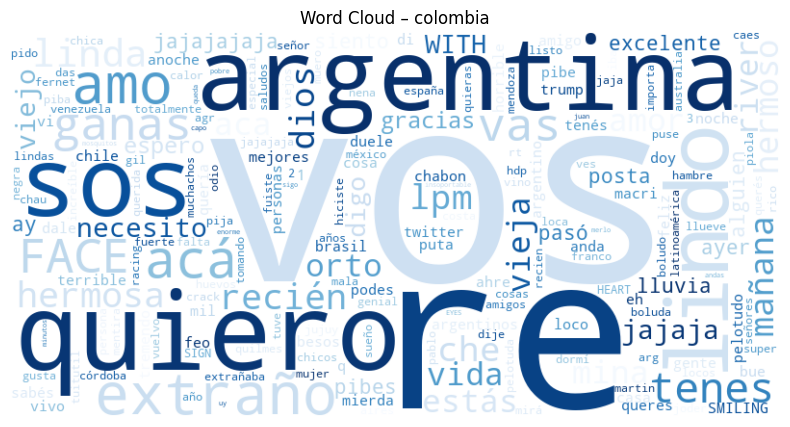

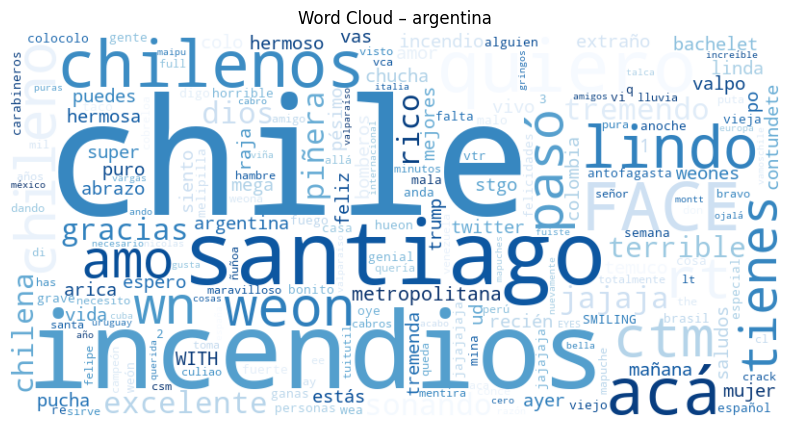

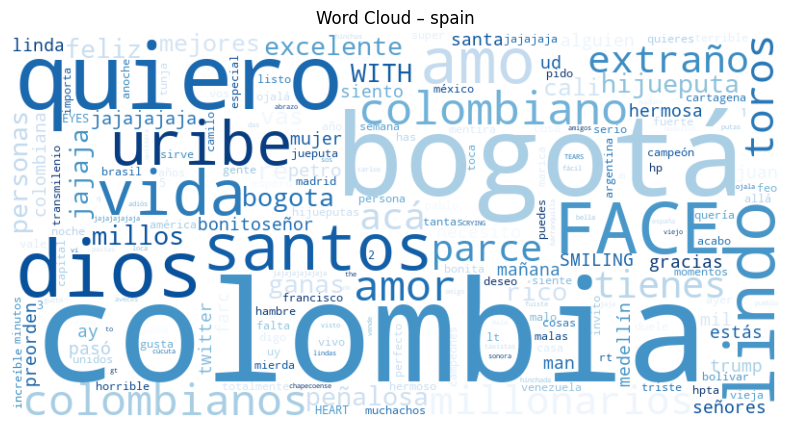

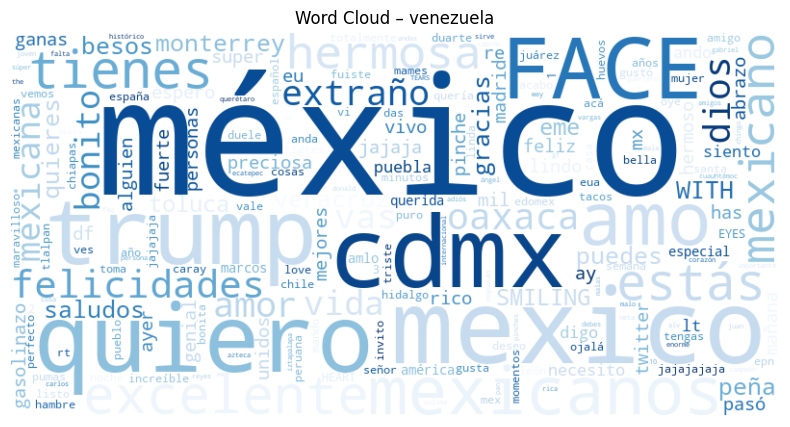

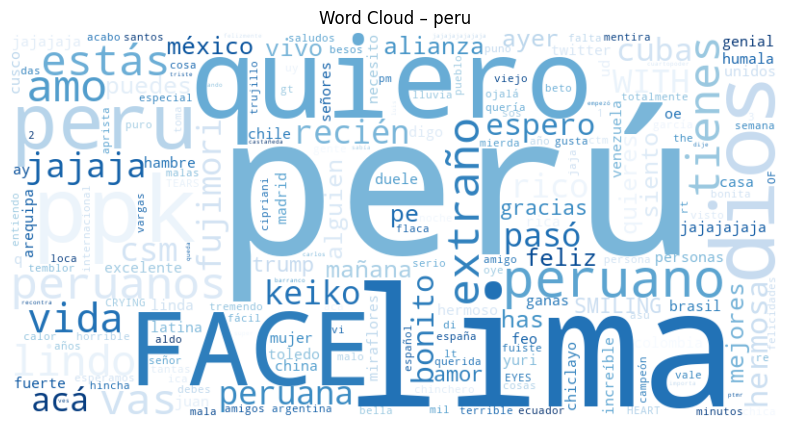

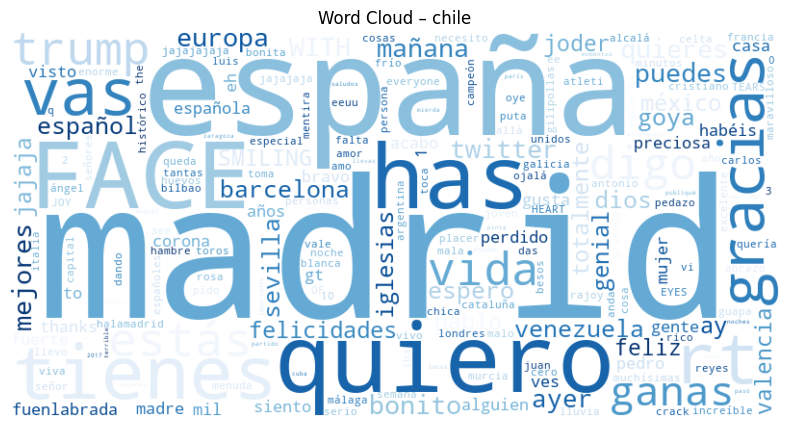

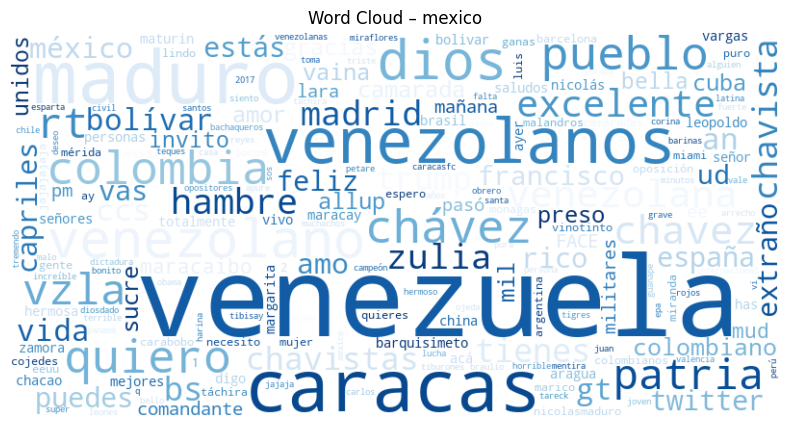

In [22]:
import collections, nltk, matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display

# Asegúrate de tener el tokenizador de NLTK listo
nltk.download('punkt', quiet=True)

class_names = {
    0: 'colombia', 1: 'argentina', 2: 'spain',
    3: 'venezuela', 4: 'peru', 5: 'chile', 6: 'mexico'
}

# 1)‑‑ acumular pesos por palabra y clase
class_word_sum = {cls: collections.defaultdict(float) for cls in class_names}

for sents, w_scores, label in zip(train_sents, train_w_scores, train_labels):
    for sent, word_scores in zip(sents, w_scores):
        # ‼️ sent puede ser string o lista; tokenizamos si hace falta
        tokens = sent if isinstance(sent, list) else nltk.word_tokenize(sent)
        for word, score in zip(tokens, word_scores[:len(tokens)]):
            class_word_sum[label][word] += score

# 2)‑‑ generar la nube
for cls, freq_dict in class_word_sum.items():
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap='Blues').generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud – {class_names[cls]}")
    plt.show()


In [22]:
import numpy as np, collections

print("Frecuencia de train_labels:", collections.Counter(train_labels))
unique_pred = len(set(train_pred))
print("Etiquetas distintas en ground‑truth:", len(set(train_labels)))
print("Etiquetas distintas en predicción :", unique_pred)


Frecuencia de train_labels: Counter({0: 1680, 1: 1680})
Etiquetas distintas en ground‑truth: 2
Etiquetas distintas en predicción : 2


In [21]:
for cls_id, freq_dict in class_word_sum.items():
    top20 = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    print(f"\nClase {cls_id} · {label_inv[cls_id]}  (top‑20):")
    for w, sc in top20:
        print(f"{w:>15s}: {sc:.3f}")



Clase 0 · female  (top‑20):
           amor: 1152.195
          feliz: 973.427
            amo: 959.866
           FACE: 935.794
          lindo: 633.610
        encanta: 535.914
     seguidores: 525.666
           vida: 520.539
          ganas: 513.342
           dios: 503.940
              q: 496.248
          gusta: 465.652
        extraño: 442.498
        corazón: 425.081
         amigos: 423.208
        gracias: 410.002
         quiero: 381.043
           WITH: 380.697
           odio: 370.535
          lista: 353.100

Clase 1 · male  (top‑20):
          feliz: 547.917
           amor: 535.045
         amigos: 502.673
              q: 490.557
          lista: 434.753
     seguidores: 425.826
          amigo: 418.248
           FACE: 412.079
         abrazo: 363.361
          gusta: 360.679
          mundo: 353.771
            amo: 341.963
           dios: 326.497
          ganas: 308.943
        gracias: 304.151
          lindo: 300.518
     disponible: 299.280
           vida: 2

Clases detectadas: {0: 'female', 1: 'male'}


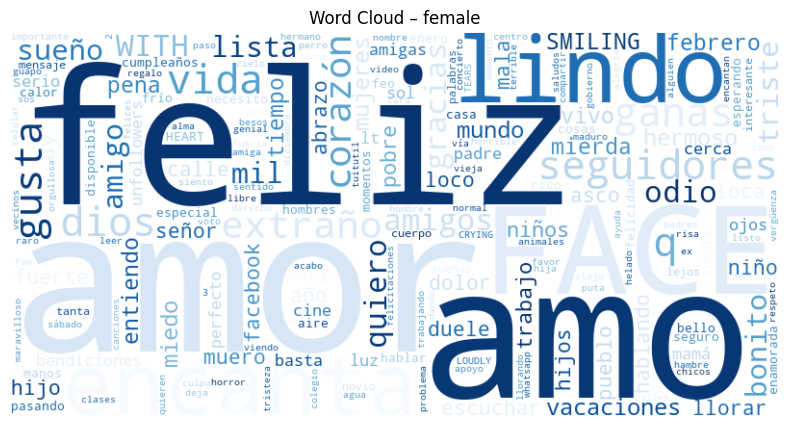

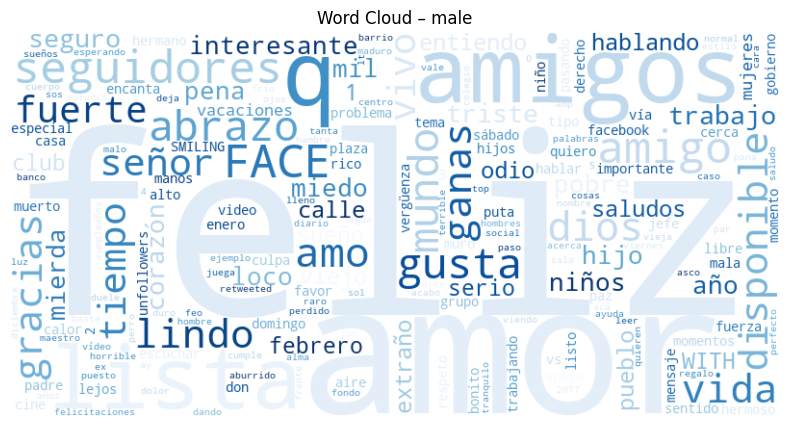

In [20]:
import collections, nltk, matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display

# 1)  Asegúrate de tener tokenizador
nltk.download("punkt", quiet=True)

# 2)  Detectamos automáticamente el mapa id → nombre‑clase desde el dataset
def get_class_names(ds):
    """
    Devuelve dict {id: nombre} manejando el caso de Subset.
    """
    if hasattr(ds, "dict_labels_inv"):        # Dataset directo
        return ds.dict_labels_inv
    elif hasattr(ds, "dataset") and hasattr(ds.dataset, "dict_labels_inv"):  # Subset
        return ds.dataset.dict_labels_inv
    else:
        raise AttributeError("No encontré dict_labels_inv en el dataset.")

class_names = get_class_names(train_dataset)   # ← train_dataset ya definido
num_classes = len(class_names)

print("Clases detectadas:", class_names)

# 3)  Acumular atención palabra × clase
class_word_sum = {cls: collections.defaultdict(float) for cls in class_names}

for sents, w_scores, label in zip(train_sents, train_w_scores, train_labels):
    for sent, word_scores in zip(sents, w_scores):
        tokens = sent if isinstance(sent, list) else nltk.word_tokenize(sent)
        for tok, score in zip(tokens, word_scores[:len(tokens)]):
            class_word_sum[label][tok] += score

# 4)  Generar nubes
for cls_id, freq_dict in class_word_sum.items():
    wc = WordCloud(width=800, height=400,
                   background_color="white",
                   colormap="Blues").generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – {class_names[cls_id]}")
    plt.show()


## Discusión

Las diferencias entre el rendimiento del modelo en el conjunto de entrenamiento y el conjunto de validación indican que el modelo se sobreajustó (estas diferencias se ven remarcadas a partir de la época 3 del entrenamiento). No obstante, las exactitudes del modelo en el conjunto de validación y en el conjunto de prueba sugieren que el modelo es capaz de generalizar bien.

# 3. **(30pts)** Para el punto anterior, construya visualizaciones como en la Figura 6 del paper de atención jerárquica y discuta.

## Librerías

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, HTML

## Funciones

In [32]:
# Función para visuzalizar la atención a nivel de palabra, tomada de https://gist.github.com/ihsgnef/f13c35cd46624c8f458a4d23589ac768
def colorize(words, color_array):
    # words es una lista de palabras
    # color_array es un arreglo de números entre 0 y 1 de longitud igual al número de palabras
    cmap = matplotlib.colormaps.get_cmap('Blues')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

## Solución

In [42]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Encontramos un índice para cada categoría predicha
ids = []
for label in range(7):
    for i, l in enumerate(train_pred):
        if l == label:
            ids.append(i)
            break

for id in ids:
    # Ground Truth
    GT = train_dataset.dataset.dict_labels_inv[train_labels[id]]
    # Predicción
    p = train_dataset.dataset.dict_labels_inv[train_pred[id]]
    print(f'GT: {GT} Predicción: {p}')

    max_attn = [np.max(scores) for scores in train_s_scores[id]]
    maxi = np.flip(np.argsort(max_attn))

    # Mapa de colores para oraciones
    cmap = matplotlib.colormaps.get_cmap('Reds')

    # Visualizamos la atención sobre las 10 oraciones más importantes
    for i in maxi[:10]:
        # Convertimos la puntuación de atención de la oración a color
        sentence_attention_color = matplotlib.colors.rgb2hex(cmap(train_s_scores[id][i])[:3])
        # Mostramos la oración y su puntuación de atención
        sentence_str = colorize(train_sents[id][i], train_w_scores[id][i][:len(train_sents[id][i])])
        sentence_html = f'<div style="border-left: 5px solid {sentence_attention_color}; padding-left: 10px;">{sentence_str}</div>'
        display(HTML(sentence_html))


GT: colombia Predicción: colombia


GT: argentina Predicción: argentina


GT: spain Predicción: spain


GT: venezuela Predicción: venezuela


GT: peru Predicción: peru


GT: chile Predicción: chile


GT: mexico Predicción: mexico


In [40]:
!pip install matplotlib

## Discusión

Como se observa, el modelo presta atención a nombres propios como "bogotá", "argentina", "caracas", "perú", "chile" y "santiago", lo cual es deseable dado que estas palabras suelen indicar aspectos demográficos que son importantes para identificar el país de origen de un usuario.

Otros términos como "vos" y "sos" sugieren que el modelo también es capaz de detectar características distintivas del español en Latinoamérica, sobretodo en países como Argentina.

En resumen, el modelo parece poner atención a palabras que son relevantes para la clasificación correcta de los documentos.

# 4. **(20pts)** Eche un ojo a los resultados que el profesor obtuvo sin deep learning ( http://ceur-ws.org/Vol-1866/paper_109.pdf ) y discuta lo siguiente respecto a tu modelo de RNN con atención en jerarquía:

## 4.1. ¿Le ganó a la mejor propuesta de representaciones distribucionales según lo reportado por el profesor? Si no fue así: ¿Le ganó a la Bolsa de Términos con SVM reportada por el profesor?

*Respuesta.* El modelo RNN basado en atención jerárquica (HAN) le ganó a la mejor propuesta de representaciones distribucionales reportada por el profesor y también a la Bolsa de Términos (BoT) con SVM en el conjunto de entrenamiento. Dicha propuesta, llamada User Specific Representation (USR), obtuvo una exactitud promedio de 90.87% en el conjunto de entrenamiento, mientras que la Bolsa de Términos con SVM logró una exactitud promedio de 85.27%. Por su parte, el modelo HAN alcanzó una exactitud mayor de 94.70%. No obstante, en el conjunto de prueba, la propuesta USR del profesor superó al modelo HAN, logrando una exactitud promedio de 89.85%, contra una exactitud de 88.42% alcanzada por el modelo HAN.

## 4.2. ¿Por qué cree que NO o SÍ le ganó? Discuta.

*Respuesta.* Yo creo que el modelo HAN no le ganó a la propuesta USR del profesor en el conjunto de prueba por dos razones. Primero, el modelo HAN supone que los documentos tienen una estrucutura jerárquica clara. Sin embargo, el texto es muy desorganizado e informal en este caso, lo cual hace que, para el modelo HAN, sea un poco más difícil capturar la información importante de los documentos.

En cambio, la propuesta USR del profesor genera mejores representaciones de documentos, más finas y menos sensibles al ruido del texto, al capturar la co-ocurrencia de palabras a lo largo de distintos documentos.

En segundo lugar, el mecanismo de atención usado por el modelo HAN puede hacer que éste se enfoque demasiado en patrones específicos del conjunto de entrenamiento, lo que, a su vez, puede llevar al sobreajuste y disminuición de la capacidad de generalización del modelo, como indican los resultados del punto 2.

## 4.3. ¿Qué usó el primer lugar de la competencia? (Basile, et al.) ( Consulte: http://ceur-ws.org/Vol-1866/ )

*Respuesta.* El primer lugar de la competencia usó un modelo llamado N-GrAM, el cual se basó en un clasificador SVM lineal con n-gramas de palabras (unigramas y bigramas) y n-gramas de caracteres (3 a 5-gramas) como características. Este modelo utilizó ponderación tf-idf con escalado sublineal de la frecuencia de términos, donde en lugar de usar el término de frecuencia estándar ($tf$) se utilizó lo siguiente:

$$1 + \log(tf)$$

Además, en el modelo se aplicó una técnica para excluir términos que eran usados por muy pocos usuarios (min_df = 2) con el objetivo de reducir el tamaño de las características y mejorar la eficiencia del modelo​.

## 4.4. ¿Cuántos y qué competidores usaron deep learning? En una o dos oraciones escriba qué hicieron, Y POR QUÉ crees que obtuvieron ese desempeño.

*Respuesta.* Los siguientes 5 competidores usaron deep learning:

1.   **Franco-Salvador et al:** Este equipo utilizó un modelo basado en Deep Averaging Networks (DAN) con embeddings de subpalabras (n-gramas de caracteres). El modelo tuvo buenos resultados, posicionándose en el lugar 10 de la competencia. En mi opinión, la combinación de los embeddings de subpalabras y una red simple como DAN, fue la causa del buen rendimiento del modelo.
2.   **Kodiyan et al:** Este equipo presentó un modelo basado en una RNN bidireccional con unidades recurrentes de compuerta (GRU), combinado con un mecanismo de atención. El modelo dio buenos resultados en general, pero no le ganó a la propuesta del profesor. Los autores comentan que ciertos puntajes bajos pueden deberse al vocabulario limitado para algunos idiomas como el árabe y el español.
3.   **Miura et al:** Este equipo implementó modelos que combinan información de palabras y caracteres con redes neuronales complejas que utilizan un mecanismo de atención con redes neuronales recurrentes (RNN) y convolucionales (CNN). Los modelos mostraron resultados muy buenos, mejores que los de muchos otros competidores. Yo creo que esto se debe principalmente al hecho de que los modelos usan información semántica (de palabras) y morfológica (de caracteres).
4.   **Schaetti et al:** Este competidor utilizó un enfoque que combinaba un modelo basado en TF-IDF y un modelo de redes neuronales convolucionales (CNN). El primer modelo alcanzó una exactitud ligeramente alta en la clasificación de variedades lingüísticas (lo cual tiene sentido ya que TF-IDF es bueno para capturar diferencias léxicas entre documentos), mientras que el segundo modelo fue más efectivo para la clasificación de género. El uso de n-gramas de letras en este último pudo haber sido la razón de su buen rendimiento.
5.   **Sierra et al:** Este equipo entrenó modelos separados para identificar el género y la variedad lingüística de los usuarios utilizando redes neuronales convolucionales (CNN). A mi parecer, obtuvieron buenos resultados (algunos incluso comparables con los obtenidos por el profesor), lo cual podría deberse a la efectividad de las CNNs para capturar patrones locales en los datos (esto es de mucha ayuda cuando se analizan textos cortos como los tweets).






# 5. **(10pts extra)** Haga una comparación que muestre si la atención en jerarquía es util vs no tenerla (e.g., sin atención o tener un solo nivel de atención)

## Solución

In [ ]:
# Definimos el modelo sin atención
model = HAN(emb_mat = train_dataset.emb_mat, attention = False).to(device)

In [ ]:
best_val_acc = 0

# Entrenamos el modelo durante las épocas deseadas
for epoch in range(epochs):
    model.train()
    for data in tqdm(train_dataloader):
        # Limpiamos basura de la memoria GPU
        torch.cuda.empty_cache()

        # Desempacamos los datos que salen del dataloader
        input_docs, labels, sentences = data

        # Movemos los datos al mismo device en el que esté el modelo
        input_docs, labels = input_docs.to(device), labels.to(device)

        # Pasamos los datos por el modelo
        output, _, _ = model(input_docs)

        # Calculamos la pérdida
        loss = criterion(output, labels)

        # Reiniciamos el cálculo del gradiente
        optimizer.zero_grad()

        # Calculamos el gradiente de la pérdida
        loss.backward()

        # Realizamos un paso de la optimización
        optimizer.step()

    # Evaluamos el modelo en los conjuntos de entrenamiento y validación
    train_loss, train_acc, _, _, _, _, _ = eval_model(model, train_dataloader, criterion, device)
    val_loss, val_acc, _, _, _, _, _ = eval_model(model, val_dataloader, criterion, device)

    print('epoch: %d'%(epoch))
    print('train_loss: %5f | val_loss: %5f | train_acc: %5f | val_acc: %5f'%(train_loss, val_loss, train_acc, val_acc))

    # Se guarda el modelo con mejor accuracy en el conjunto de validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = copy.deepcopy(model.state_dict())

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 0
train_loss: 1.951399 | val_loss: 1.952368 | train_acc: 0.144345 | val_acc: 0.146429


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 1
train_loss: 1.951399 | val_loss: 1.952368 | train_acc: 0.144345 | val_acc: 0.146429


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 2
train_loss: 1.951399 | val_loss: 1.952368 | train_acc: 0.144345 | val_acc: 0.146429


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 3
train_loss: 1.951399 | val_loss: 1.952368 | train_acc: 0.144345 | val_acc: 0.146429


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 4
train_loss: 1.951399 | val_loss: 1.952368 | train_acc: 0.144345 | val_acc: 0.146429


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 5
train_loss: 1.951399 | val_loss: 1.952368 | train_acc: 0.144345 | val_acc: 0.146429


In [ ]:
# Cargamos el mejor modelo y lo evaluamos en los tres conjuntos
model.load_state_dict(best_state_dict)

train_loss, train_acc, _, _, _, _, _ = eval_model(model, train_dataloader, criterion, device)
val_loss, val_acc, _, _, _, _, _ = eval_model(model, val_dataloader, criterion, device)
test_loss, test_acc, _, _, _, _, _ = eval_model(model, test_dataloader, criterion, device)

print('train_loss: %5f | train_acc: %5f'%(train_loss, train_acc))
print('val_loss: %5f | val_acc: %5f'%(val_loss, val_acc))
print('test_loss: %5f | test_acc: %5f'%(test_loss, test_acc))

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

train_loss: 1.951399 | train_acc: 0.144345
val_loss: 1.952368 | val_acc: 0.146429
test_loss: 1.950289 | test_acc: 0.147500


## Discusión

Como se esperaba, al eliminar la atención y reemplazarla por mean pooling, el modelo obtiene peores resultados. Esto puede deberse en gran medida al hecho de que mean pooling asigna el mismo peso a todas las palabras y oraciones, lo cual reduce significativamente la capacidad del modelo para identificar las características o patrones más importantes para la clasificación.

La atención empleada por el modelo HAN permitía hacer un uso mucho más eficiente de la información. En cambio, el mean pooling vuelve "indiferente" esa información, tratando todo por igual.